In [1]:
from graph_tool.all import *
import graph_tool.all as gt
import numpy as np
import scipy as sp
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PyGnuplot import gp
import subprocess
from scipy.integrate import simpson

In [2]:
Node = 1000

m = 2

times = 100

beta_list = [1,-1]

net_list = ["SF", "IPA_beta1"]

name_list = ["SF", "ER"]

In [3]:
# 第二固有値と固有ベクトルを算出する関数
def no_normalized_laplacian(g):
    # ラプラシアン行列の計算
    # `normalized` 引数を削除
    L = gt.laplacian(g)
    
    # scipyのスパース行列としてラプラシアン行列を取得
    L_sparse = sp.sparse.csr_matrix(L)
    
    # 固有値と固有ベクトルの計算 (第二小さい固有値とその固有ベクトルを求める)
    eigenvalues, eigenvectors = sp.sparse.linalg.eigsh(L_sparse, k=2, which='SM')
    
    second_values = eigenvalues[1]
    
    # フィードラーベクトル (第二小さい固有値に対応する固有ベクトル) の抽出
    fiedler_vector = eigenvectors[:, 1]
    
    return second_values, fiedler_vector

In [4]:
count_list = [0,1,2,5,10,20,50,100,200,500,1000]
recalculate_list = [0,1000,500,200,100,50,20,10,5,2,1]

all_SF_μ = []

for count, recalculate in zip(count_list, recalculate_list):
    part_μ = []
    if count == recalculate == 0:
        for i in range(times):
            g = load_graph(f"~/o_t_hayashilab/complex_networks_2024/Network_data/N={Node}/SF/initial/{i}.gt.gz")
            
            μ, fiedler_vector = no_normalized_laplacian(g)
            
            part_μ.append(μ)
    
        ave_μ = np.mean(part_μ)
    
        all_SF_μ.append(ave_μ)
        
    else: 
        for i in tqdm(range(times)):
            g = load_graph(f"~/o_t_hayashilab/complex_networks_2024/Network_data/N={Node}/SF/c={count}_re={recalculate}/{i}.gt.gz")
            
            μ, fiedler_vector = no_normalized_laplacian(g)
            
            part_μ.append(μ)
        
        ave_μ = np.mean(part_μ)
        
        all_SF_μ.append(ave_μ)
        
all_ER_μ = []

for count, recalculate in zip(count_list, recalculate_list):
    part_μ = []
    if count == recalculate == 0:
        for i in range(times):
            g = load_graph(f"~/o_t_hayashilab/complex_networks_2024/Network_data/N={Node}/ER/initial/{i}.gt.gz")
            
            μ, fiedler_vector = no_normalized_laplacian(g)
            
            part_μ.append(μ)
    
        ave_μ = np.mean(part_μ)
    
        all_ER_μ.append(ave_μ)
        
    else: 
        for i in tqdm(range(times)):
            g = load_graph(f"~/o_t_hayashilab/complex_networks_2024/Network_data/N={Node}/ER/c={count}_re={recalculate}/{i}.gt.gz")
            
            μ, fiedler_vector = no_normalized_laplacian(g)
            
            part_μ.append(μ)
        
        ave_μ = np.mean(part_μ)
        
        all_ER_μ.append(ave_μ)

100%|██████████| 100/100 [00:07<00:00, 14.16it/s]


In [5]:
#チェーン構造を解消するためのリワイヤリングコード
def rewire_network(g, rewiring_times):
    #print("random_rewire開始")
    gt.random_rewire(g, model = "configuration", n_iter = rewiring_times, edge_sweep=True)
    #print("random_rewire終了")
    return g

# Define function to check sum_u
def check_sum_u(g, target_sum):
    l = gt.label_largest_component(g)
    u = gt.GraphView(g, vfilt=l)
    sum_u = u.num_vertices()
    return sum_u == target_sum

In [6]:
SF_config = []
ER_config = []
count_list = [1,2,5,10,20,50,100,200,500,1000]
recalculate_list = [1000,500,200,100,50,20,10,5,2,1]

for count, recalculate in zip(count_list, recalculate_list):
    for net in name_list:
        config = []
        for i in tqdm(range(times)):
            if "SF" in net:
                while True:
                    g = load_graph(f"~/o_t_hayashilab/complex_networks_2024/Network_data/N={Node}/{net}/c={count}_re={recalculate}/{i}.gt.gz")
                    # 初期グラフを保存する前にコピーする
                    G = g.copy()
                    G = rewire_network(G, Node)
                    if check_sum_u(G, Node):
                        break
                config.append(G)
            
            else:
                while True:
                    g = load_graph(f"~/o_t_hayashilab/complex_networks_2024/Network_data/N={Node}/{net}/c={count}_re={recalculate}/{i}.gt.gz")
                    # 初期グラフを保存する前にコピーする
                    G = g.copy()
                    G = rewire_network(G, Node)
                    if check_sum_u(G, Node):
                        break
                config.append(G)
                
        if "SF" in net:
            SF_config.append(config)
        else:
            ER_config.append(config)

100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


In [ ]:
count_list = [5, 20, 50, 100, 200, 500, 1000, 2500, 5000]
recalculate_list = [1000, 250, 100, 50, 25, 10, 5, 2, 1]

for count, recalculate in zip(count_list, recalculate_list):
    for net in name_list:
        for i in tqdm(range(times)):
            attempt = 0
            while attempt < 500:
                g = load_graph(f"~/o_t_hayashilab/Network_data/graph-tool/rewire_laplacian/N={Node}/{net}/c={count}_re={recalculate}/{i}.gt.gz")
                G = g.copy()
                G = rewire_network(G, Node)
                
                if check_sum_u(G, Node):
                    directory = (f"~/o_t_hayashilab/Network_data/graph-tool/rewire_laplacian/N={Node}/config/{net}/c={count}_re={recalculate}/")
                    os.makedirs(os.path.expanduser(directory), exist_ok=True)
                    filename = directory + f"{i}.gt.gz"
                    G.save(filename)
                    break
                
                attempt += 1

In [7]:
all_SF_config_μ = []
part_μ = []
for i in range(len(SF_config)):
    for j in range(times):
        
        g = SF_config[i][j]
        μ, fiedler_vector = no_normalized_laplacian(g)
    
        part_μ.append(μ)

    ave_μ = np.mean(part_μ)

    all_SF_config_μ.append(ave_μ)
        
all_ER_config_μ = []
for i in range(len(ER_config)):
    part_μ = []
    for j in range(times):
        
        g = ER_config[i][j]
        μ, fiedler_vector = no_normalized_laplacian(g)
    
        part_μ.append(μ)

    ave_μ = np.mean(part_μ)

    all_ER_config_μ.append(ave_μ)

In [8]:
all_SF_μ

[0.20220013901014172,
 0.49382091033743,
 0.5713367571185703,
 0.4800560233408595,
 0.411755928701528,
 0.35580611775476456,
 0.3028815247248909,
 0.2938488617374591,
 0.25622851920908285,
 0.24898680178521157,
 0.36180617221454064]

In [9]:
all_ER_μ

[0.3135116583338272,
 0.527746979056443,
 0.5808093014101583,
 0.4711043769879607,
 0.4083507856891591,
 0.3669682999881397,
 0.32326472026503145,
 0.29748350226593356,
 0.26641394321863077,
 0.26017016574965646,
 0.40546926567834823]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


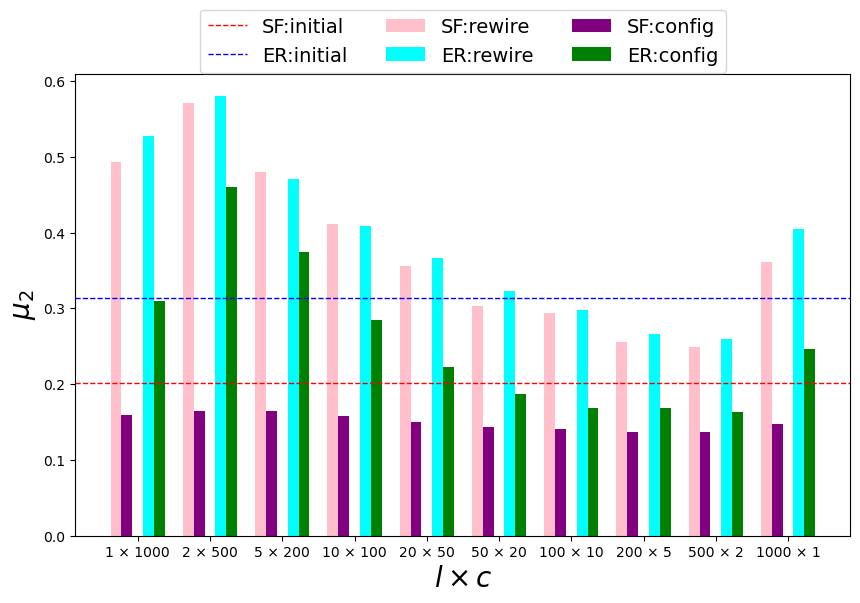

R_SF: [0.20220013901014172, 0.49382091033743, 0.5713367571185703, 0.4800560233408595, 0.411755928701528, 0.35580611775476456, 0.3028815247248909, 0.2938488617374591, 0.25622851920908285, 0.24898680178521157, 0.36180617221454064]
R_SF_config: [0.15955328887028938, 0.16446412176934225, 0.16504917897163734, 0.15788209808397274, 0.14994078374273695, 0.14384700329449643, 0.14045004524674917, 0.13757363895065777, 0.1372062136224114, 0.14775950666374063]
R_ER: [0.3135116583338272, 0.527746979056443, 0.5808093014101583, 0.4711043769879607, 0.4083507856891591, 0.3669682999881397, 0.32326472026503145, 0.29748350226593356, 0.26641394321863077, 0.26017016574965646, 0.40546926567834823]
R_ER_config: [0.3104245519133397, 0.4599070623115022, 0.37475260560547924, 0.284158585094543, 0.2230375402207929, 0.1868767938861543, 0.16909431716630763, 0.16819301100917108, 0.1631019695771807, 0.24619877496992726]


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# x軸のラベル (initial を削除)
x_labels = ['1 × 1000', '2 × 500', '5 × 200', '10 × 100', '20 × 50', '50 × 20', '100 × 10', '200 × 5', '500 × 2', '1000 × 1']

# 各グラフのx値を設定
x_indices = list(range(len(x_labels)))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the rest of the values for 5, 10, 50, 100, 200, 500
x_sf_l = np.array(x_indices) - 0.3  # 左にずらす
y_sf_l = all_SF_μ[1:]
x_sf_config = np.array(x_indices) - 0.15  # 少し左にずらす
y_sf_config = all_SF_config_μ
x_er_l = np.array(x_indices) + 0.15  # 少し右にずらす
y_er_l = all_ER_μ[1:]
x_er_config = np.array(x_indices) + 0.3  # 右にずらす
y_er_config = all_ER_config_μ

# Plot the bars
bar_sf_l = plt.bar(x_sf_l, y_sf_l, width=0.15, color='pink', label='SF:rewire')
bar_sf_config = plt.bar(x_sf_config, y_sf_config, width=0.15, color='purple', label='SF:config')
bar_er_l = plt.bar(x_er_l, y_er_l, width=0.15, color='cyan', label='ER:rewire')
bar_er_config = plt.bar(x_er_config, y_er_config, width=0.15, color='green', label='ER:config')

# Adding horizontal lines for initial values (dashed)
plt.axhline(y=all_SF_μ[0], color='red', linestyle='--', linewidth=1, label='SF:initial')
plt.axhline(y=all_ER_μ[0], color='blue', linestyle='--', linewidth=1, label='ER:initial')

# Labeling the x-axis
plt.xticks(ticks=x_indices, labels=x_labels)

# Adding titles and labels
plt.xlabel(r'$l \times c$', fontsize=20)
plt.ylabel(r"$μ_{2}$", fontsize=20)

# Placing the legend outside the plot on the top center
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2, 4, 3, 5]
plt.legend([handles[idx] for idx in order], 
           ['SF:initial', 'ER:initial', 'SF:rewire', 'ER:rewire', 'SF:config', 'ER:config'], 
           loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3, fontsize=14)

# 保存先のディレクトリを指定
save_dir = os.path.expanduser('~/o_t_hayashilab/complex_networks_2024/figure/')
os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成
# EPS形式で図を保存（フルパスを指定）
save_path = os.path.join(save_dir, f"eigenvalue.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')

# Show plot
plt.show()

# Print results
print("R_SF:", all_SF_μ)
print("R_SF_config:", all_SF_config_μ)
print("R_ER:", all_ER_μ)
print("R_ER_config:", all_ER_config_μ)

In [11]:
R_SF = []
R_ER = []
count_list = [0,1,2,5,10,20,50,100,200,500,1000]
recalculate_list = [0,1000,500,200,100,50,20,10,5,2,1]

for net in name_list:
    for count, recalculate in zip(count_list, recalculate_list):
        IB = []
        if count == recalculate == 0:
            for i in range(times):
                g = load_graph(f"~/o_t_hayashilab/complex_networks_2024/Network_data/N={Node}/{net}/initial/{i}.gt.gz")
                
                G = g.copy()
                
                vertex_IB_list, edge_IB_list = gt.betweenness(G)
                vertex_list = [v for v in G.vertices()]
                randomized_vertex_list = list(range(0, len(vertex_list)))
                random.shuffle(randomized_vertex_list)
                combined_vertex_list = list(zip(vertex_list, vertex_IB_list, randomized_vertex_list))
                sorted_combined_vertex_list = sorted(combined_vertex_list, key=lambda v: (v[1], v[2]))
                IB_rewiring_g = [v for (v, s, t) in sorted_combined_vertex_list]
        
                sizes, comp = gt.vertex_percolation(G, IB_rewiring_g)
                betweenness_attack = [frc for frc in sizes]
                perc = np.array(betweenness_attack)
                perc = perc / Node
                IB.append(perc)
        
            IB_avg = np.mean(IB, axis=0)
            R = simpson(IB_avg, dx=1/Node)
            if "SF" in net:
                R_SF.append(R)
            else:
                R_ER.append(R)
        else:
            for i in range(times):
                g = load_graph(f"~/o_t_hayashilab/complex_networks_2024/Network_data/N={Node}/{net}/c={count}_re={recalculate}/{i}.gt.gz")
                
                G = g.copy()
                
                vertex_IB_list, edge_IB_list = gt.betweenness(G)
                vertex_list = [v for v in G.vertices()]
                randomized_vertex_list = list(range(0, len(vertex_list)))
                random.shuffle(randomized_vertex_list)
                combined_vertex_list = list(zip(vertex_list, vertex_IB_list, randomized_vertex_list))
                sorted_combined_vertex_list = sorted(combined_vertex_list, key=lambda v: (v[1], v[2]))
                IB_rewiring_g = [v for (v, s, t) in sorted_combined_vertex_list]
        
                sizes, comp = gt.vertex_percolation(G, IB_rewiring_g)
                betweenness_attack = [frc for frc in sizes]
                perc = np.array(betweenness_attack)
                perc = perc / Node
                IB.append(perc)
        
            IB_avg = np.mean(IB, axis=0)
            R = simpson(IB_avg, dx=1/Node)
            if "SF" in net:
                R_SF.append(R)
            else:
                R_ER.append(R)

In [12]:
R_SF_config = []
R_ER_config = []

for net in name_list:
    
    for i in range(len(SF_config)):
        IB = []
        for j in range(times):
            if "SF" in net:
                g = SF_config[i][j]
                
            else:
                g = ER_config[i][j]
                
            G = g.copy()
            
            vertex_IB_list, edge_IB_list = gt.betweenness(G)
            vertex_list = [v for v in G.vertices()]
            randomized_vertex_list = list(range(0, len(vertex_list)))
            random.shuffle(randomized_vertex_list)
            combined_vertex_list = list(zip(vertex_list, vertex_IB_list, randomized_vertex_list))
            sorted_combined_vertex_list = sorted(combined_vertex_list, key=lambda v: (v[1], v[2]))
            IB_rewiring_g = [v for (v, s, t) in sorted_combined_vertex_list]
    
            sizes, comp = gt.vertex_percolation(G, IB_rewiring_g)
            betweenness_attack = [frc for frc in sizes]
            perc = np.array(betweenness_attack)
            perc = perc / Node
            IB.append(perc)
    
        IB_avg = np.mean(IB, axis=0)
        R = simpson(IB_avg, dx=1/Node)
        
        if "SF" in net:
            R_SF_config.append(R)
        else:
            R_ER_config.append(R)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


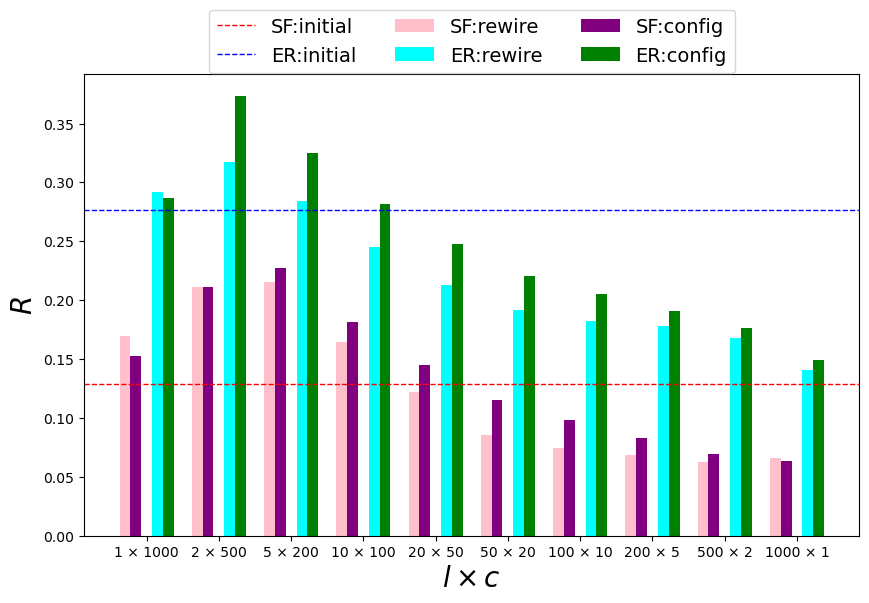

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# x軸のラベル (initial を削除)
x_labels = ['1 × 1000', '2 × 500', '5 × 200', '10 × 100', '20 × 50', '50 × 20', '100 × 10', '200 × 5', '500 × 2', '1000 × 1']

# 各グラフのx値を設定
x_indices = list(range(len(x_labels)))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the rest of the values for 5, 10, 50, 100, 200, 500
x_sf_l = np.array(x_indices) - 0.3  # 左にずらす
y_sf_l = R_SF[1:]
x_sf_config = np.array(x_indices) - 0.15  # 少し左にずらす
y_sf_config = R_SF_config
x_er_l = np.array(x_indices) + 0.15  # 少し右にずらす
y_er_l = R_ER[1:]
x_er_config = np.array(x_indices) + 0.3  # 右にずらす
y_er_config = R_ER_config

# Plot the bars
bar_sf_l = plt.bar(x_sf_l, y_sf_l, width=0.15, color='pink', label='SF:rewire')
bar_sf_config = plt.bar(x_sf_config, y_sf_config, width=0.15, color='purple', label='SF:config')
bar_er_l = plt.bar(x_er_l, y_er_l, width=0.15, color='cyan', label='ER:rewire')
bar_er_config = plt.bar(x_er_config, y_er_config, width=0.15, color='green', label='ER:config')

# Adding horizontal lines for initial values (dashed)
plt.axhline(y=R_SF[0], color='red', linestyle='--', linewidth=1, label='SF:initial')
plt.axhline(y=R_ER[0], color='blue', linestyle='--', linewidth=1, label='ER:initial')

# Labeling the x-axis
plt.xticks(ticks=x_indices, labels=x_labels)

# Adding titles and labels
plt.xlabel(r'$l \times c$', fontsize=20)
plt.ylabel(r"$R$", fontsize=20)

# Placing the legend outside the plot on the top center
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2, 4, 3, 5]
plt.legend([handles[idx] for idx in order], 
           ['SF:initial', 'ER:initial', 'SF:rewire', 'ER:rewire', 'SF:config', 'ER:config'], 
           loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3, fontsize=14)

# 保存先のディレクトリを指定
save_dir = os.path.expanduser('~/o_t_hayashilab/complex_networks_2024/figure/')
os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成
# EPS形式で図を保存（フルパスを指定）
save_path = os.path.join(save_dir, f"R^IB.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')

# Show plot
plt.show()

In [24]:
from scipy.stats import pearsonr
# 単相関係数を計算して表示する関数
def calculate_and_display_correlation(x_values, y_values, label):
    correlation, _ = pearsonr(x_values, y_values)
    print(f"{label} の単相関係数: {correlation:.4f}")
    return correlation

SF:rewire の単相関係数: 0.9225
ER:rewire の単相関係数: 0.8515
SF:config の単相関係数: 0.9095
ER:config の単相関係数: 0.8865


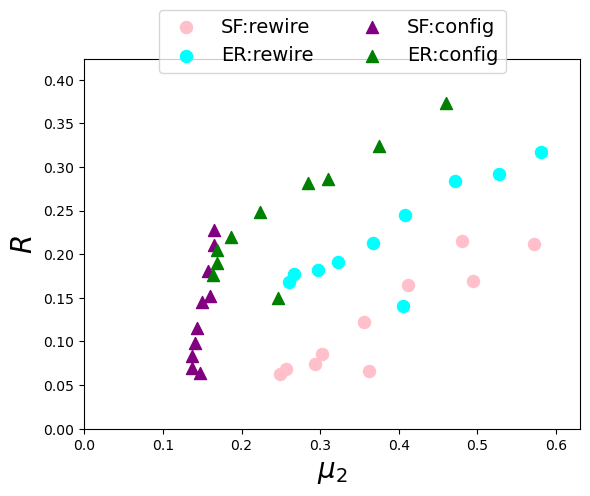

In [25]:
# SF:rewire の散布図と単相関係数
correlation_SF_rewire = calculate_and_display_correlation(all_SF_μ[1:], R_SF[1:], label='SF:rewire')
plot_correlation(all_SF_μ[1:], R_SF[1:], label='SF:rewire', color='pink', size=75)

# ER:rewire の散布図と単相関係数
correlation_ER_rewire = calculate_and_display_correlation(all_ER_μ[1:], R_ER[1:], label='ER:rewire')
plot_correlation(all_ER_μ[1:], R_ER[1:], label='ER:rewire', color='cyan', size=75)

# SF:config の散布図と単相関係数
correlation_SF_config = calculate_and_display_correlation(all_SF_config_μ, R_SF_config, label='SF:config')
plot_correlation(all_SF_config_μ, R_SF_config, label='SF:config', color='purple', marker='^', size=75)

# ER:config の散布図と単相関係数
correlation_ER_config = calculate_and_display_correlation(all_ER_config_μ, R_ER_config, label='ER:config')
plot_correlation(all_ER_config_μ, R_ER_config, label='ER:config', color='green', marker='^', size=75)

# 軸ラベルの設定
plt.xlabel(r"$μ_{2}$", fontsize=20)
plt.ylabel(r"$R$", fontsize=20)

# x軸の範囲を設定（0から最大値+0.05）
plt.xlim(0, max(max(all_SF_μ[1:]), max(all_SF_config_μ), max(all_ER_μ[1:]), max(all_ER_config_μ)) + 0.05)

# y軸の範囲を設定（0から最大値+0.05）
plt.ylim(0, max(max(R_SF[1:]), max(R_SF_config), max(R_ER[1:]), max(R_ER_config)) + 0.05)

# 凡例の設定（上に2×2で配置）
plt.legend(loc='upper center', fontsize=14, bbox_to_anchor=(0.5, 1.16), ncol=2)

# プロットの表示
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


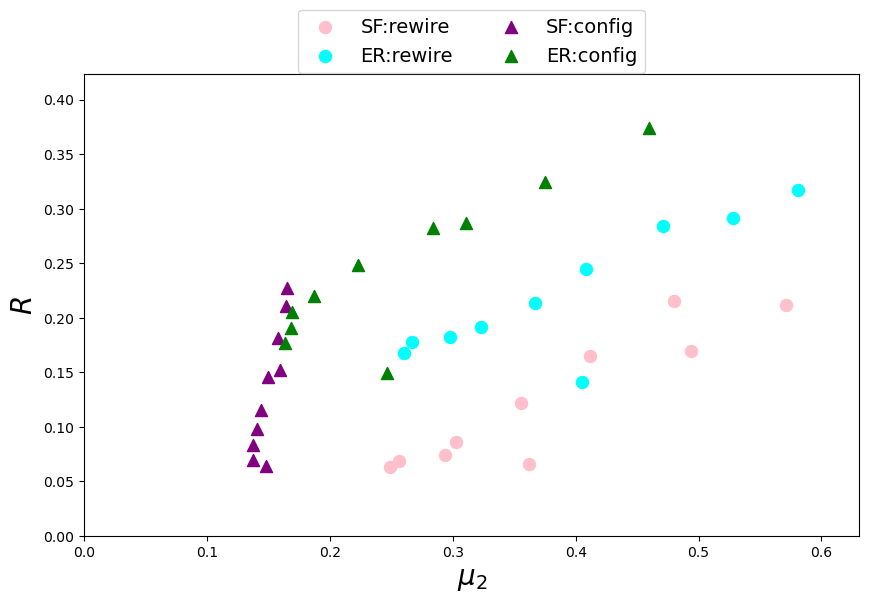

In [23]:
import matplotlib.pyplot as plt

# 散布図を作成する関数（点線のプロットを除去）
def plot_correlation(x_values, y_values, label, color, marker='o', size=100):  # size引数を追加
    plt.scatter(x_values, y_values, label=label, color=color, marker=marker, s=size)

# 散布図を作成
plt.figure(figsize=(10, 6))

# SF:rewire の散布図
plot_correlation(all_SF_μ[1:], R_SF[1:], label='SF:rewire', color='pink', size=75)

# ER:rewire の散布図
plot_correlation(all_ER_μ[1:], R_ER[1:], label='ER:rewire', color='cyan', size=75)

# SF:config の散布図
plot_correlation(all_SF_config_μ, R_SF_config, label='SF:config', color='purple', marker='^', size=75)

# ER:config の散布図
plot_correlation(all_ER_config_μ, R_ER_config, label='ER:config', color='green', marker='^', size=75)

# 軸ラベルの設定
plt.xlabel(r"$μ_{2}$", fontsize=20)
plt.ylabel(r"$R$", fontsize=20)

# x軸の範囲を設定（0から最大値+0.05）
plt.xlim(0, max(max(all_SF_μ[1:]), max(all_SF_config_μ), max(all_ER_μ[1:]), max(all_ER_config_μ)) + 0.05)

# y軸の範囲を設定（0から最大値+0.05）
plt.ylim(0, max(max(R_SF[1:]), max(R_SF_config), max(R_ER[1:]), max(R_ER_config)) + 0.05)

# 凡例の設定（上に2×2で配置）
plt.legend(loc='upper center', fontsize=14, bbox_to_anchor=(0.5, 1.16), ncol=2)

# 保存先のディレクトリを指定
save_dir = os.path.expanduser('~/o_t_hayashilab/complex_networks_2024/figure/')
os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成
# EPS形式で図を保存（フルパスを指定）
save_path = os.path.join(save_dir, f"mu2_R^IB_correlation.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')

# プロットの表示
plt.show()

In [15]:
var_SF = []
var_ER = []
for net in name_list:
    for count, recalculate in zip(count_list, recalculate_list):
        var = []
        if count == recalculate == 0:
            for i in range(times):
                g = load_graph(f"~/o_t_hayashilab/complex_networks_2024/Network_data/N={Node}/{net}/initial/{i}.gt.gz")
                                
                G = g.copy()
                
                degrees = G.degree_property_map("total").a
                degrees_var = float(np.var(degrees))
                
                var.append(degrees_var)
        
            var_avg = np.mean(var, axis=0)
            if "SF" in net:
                var_SF.append(var_avg)
            else:
                var_ER.append(var_avg)
        else:
            for i in range(times):
                g = load_graph(f"~/o_t_hayashilab/complex_networks_2024/Network_data/N={Node}/{net}/c={count}_re={recalculate}/{i}.gt.gz")
                
                G = g.copy()
                
                degrees = G.degree_property_map("total").a
                degrees_var = float(np.var(degrees))
                
                var.append(degrees_var)
        
            var_avg = np.mean(var, axis=0)
            if "SF" in net:
                var_SF.append(var_avg)
            else:
                var_ER.append(var_avg)

In [16]:
var_SF_config = []
var_ER_config = []
for net in name_list:
    for i in range(len(SF_config)):
        var = []
        for j in range(times):
            if "SF" in net:
                g = SF_config[i][j]
                
            else:
                g = ER_config[i][j]
            
            G = g.copy()
            
            degrees = G.degree_property_map("total").a
            degrees_var = float(np.var(degrees))
            
            var.append(degrees_var)
    
        var_avg = np.mean(var, axis=0)
        if "SF" in net:
            var_SF_config.append(var_avg)
        else:
            var_ER_config.append(var_avg)

In [17]:
import pandas as pd

x_labels = ['initial', '1 × 1000', '2 × 500', '5 × 200', '10 × 100', '20 × 50', '50 × 20', '100 × 10', '200 × 5', '500 × 2', '1000 × 1']

# 各データの準備
data = {
    'l × c': x_labels,
    'SF': var_SF,
    'ER': var_ER
}

# DataFrameの作成
df = pd.DataFrame(data)

# DataFrameをCSVファイルとして保存 (インデックスなし)
df.to_csv('data_summary.csv', index=False)

# インデックスなしでDataFrameを表示
print(df.to_string(index=False))

   l × c         SF         ER
 initial  27.906364   3.228204
1 × 1000  24.980704   2.906624
 2 × 500  17.447384   1.066504
 5 × 200  13.008944   1.814404
10 × 100  15.154064   3.489364
 20 × 50  19.365584   7.508984
 50 × 20  32.719624  21.698924
100 × 10  54.297804  46.348364
 200 × 5  97.112784  95.781904
 500 × 2 220.608364 241.757124
1000 × 1 686.881504 640.073584
